In [6]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
advanced_df = pd.read_csv("dataset_mood_smartphone (1).csv", index_col=0)

In [8]:
advanced_df.head()

,id,time,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.0
2,AS14.01,2014-02-26 15:00:00.000,mood,6.0
3,AS14.01,2014-02-26 18:00:00.000,mood,6.0
4,AS14.01,2014-02-26 21:00:00.000,mood,7.0
5,AS14.01,2014-02-27 09:00:00.000,mood,6.0


## Define functions

In [9]:
# Check the shape of a dataframe, along with NaN values
def check_df(df):
    print(df.shape)
    for item in df.columns:
        print(item, ': ', type(df[item]), ', contains NaN:',df[item].isnull().values.any())

# Plot all the variables vs time
def plot_feature(df, variable_name, participant=None):
    ylabel_text = f"{variable_name} value"
    title_text = f"{variable_name} vs time"

    if participant:
        plot = df[(df['variable'] == variable_name) & (df['id'] == participant)]
    else:
        plot = df[(df['variable'] == variable_name)]

    plt.plot(plot['time'], plot['value'])
    plt.xlabel('time')
    plt.ylabel(ylabel_text)
    plt.title(title_text)
    plt.legend(loc='lower right')
    plt.show()

# Plot histograms of all the variables
def plot_histograms(df, variable_name, participant=None):

    if participant:
        df[(df['variable'] == variable_name) & (df['id'] == participant)].plot(kind='hist', edgecolor='black')
    else:
        df[(df['variable'] == variable_name)].plot(kind='hist', edgecolor='black')

    plt.xlabel(variable_name)
    plt.legend(loc='lower right')

# Remove outliers >0.75 and <0.25 of all values, excepting mood, call, sms etc
def remove_outliers(df, column_name, multiplier=1.5):
    exception_list = ['mood', 'sms', 'call', 'circumplex.arousal', 'circumplex.valence', 'activity']
    if column_name in exception_list:
        return
    q1 = df[column_name].quantile(0.25)
    q2 = df[column_name].quantile(0.75)
    iqr = q2 - q1
    lower_bound = q1 - multiplier * iqr
    upper_bound = q2 + multiplier * iqr
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

# Compare 2 histograms
def histogram_comparison(df1, df2, variable_name, participant=None):
    if participant:
        plot1 = df1[(df1['variable'] == variable_name) & (df1['id'] == participant)]
        plot2 = df2[(df2['variable'] == variable_name) & (df2['id'] == participant)]
    else:
        plot1 = df1[(df1['variable'] == variable_name)]
        plot2 = df2[(df2['variable'] == variable_name)]
    plt.hist(plot1, label = df1, alpha=0.5, bins = 10, color= ['yellow', 'yellow','yellow', 'yellow'])
    plt.hist(plot2, label = df2, alpha = 0.5, bins = 10, color = ['purple', 'purple','purple', 'purple'])
    plt.legend(loc='lower right')
    plt.xlabel(f"{variable_name} value")
    plt.ylabel('Frequency')
    plt.title('Comparing two histograms')
    plt.show()

# Check a dataframe for class balance
def check_class_balance(df, target_column):
    print(df[target_column].value_counts())

## Check for dataframe shape and NaN values

In [10]:
check_df(advanced_df)

(376912, 4)
id :  <class 'pandas.core.series.Series'> , contains NaN: False
time :  <class 'pandas.core.series.Series'> , contains NaN: False
variable :  <class 'pandas.core.series.Series'> , contains NaN: False
value :  <class 'pandas.core.series.Series'> , contains NaN: True


## Drop rows with NaN values

In [11]:
advanced_df.dropna(inplace=True)
check_df(advanced_df)

(376710, 4)
id :  <class 'pandas.core.series.Series'> , contains NaN: False
time :  <class 'pandas.core.series.Series'> , contains NaN: False
variable :  <class 'pandas.core.series.Series'> , contains NaN: False
value :  <class 'pandas.core.series.Series'> , contains NaN: False


## Sort dataframe by id and time

In [12]:
advanced_df.sort_values(['id', 'time'], inplace=True)

## Plot all features vs time for participant AS14.01

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


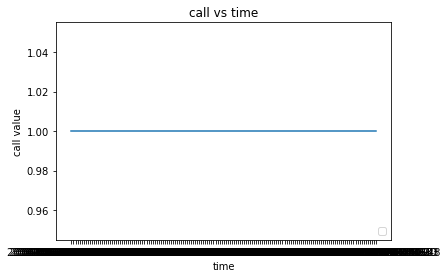

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


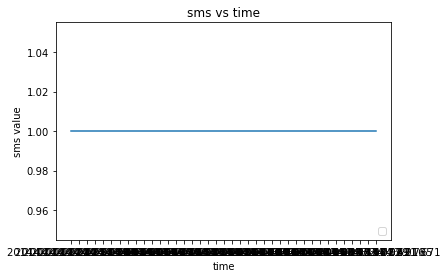

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


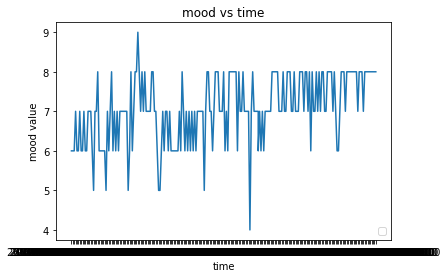

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


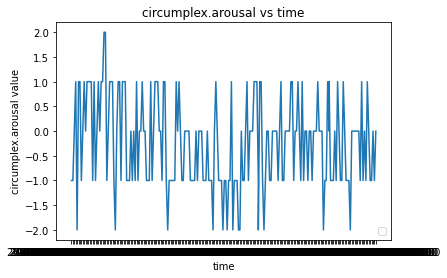

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


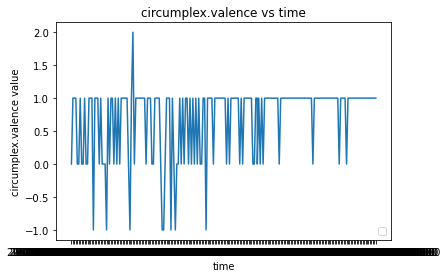

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


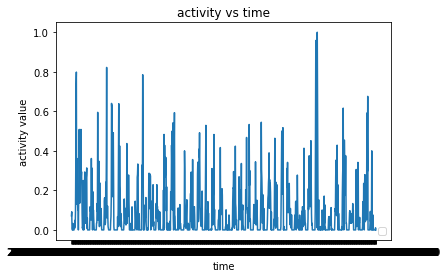

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


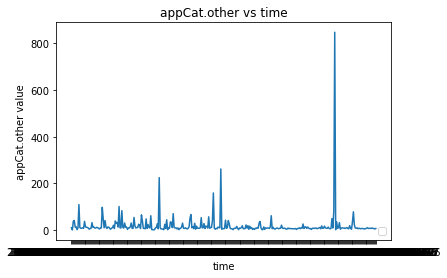

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


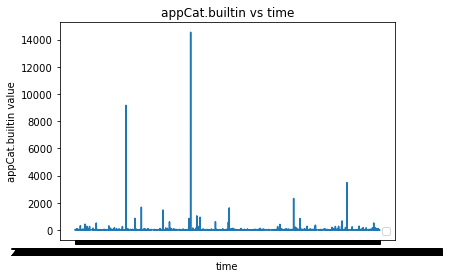

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


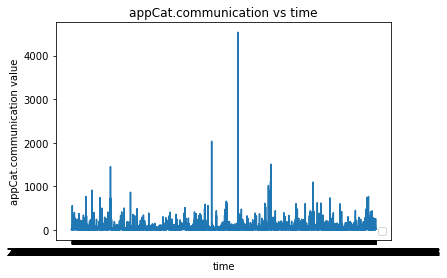

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


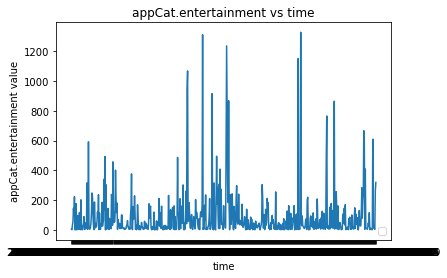

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


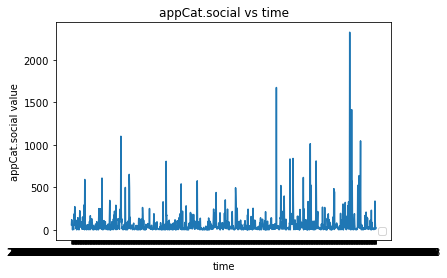

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


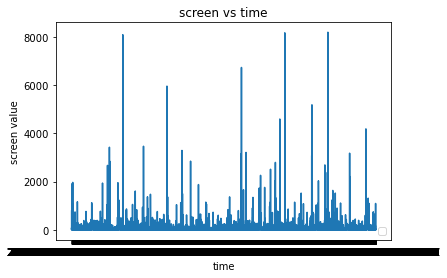

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


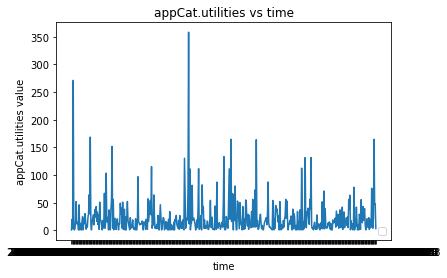

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


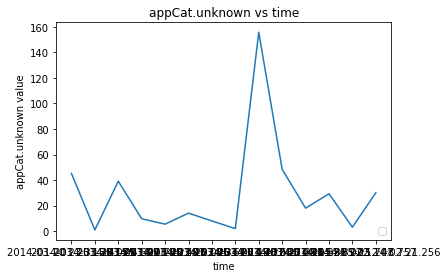

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


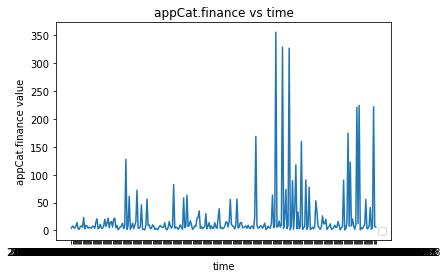

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


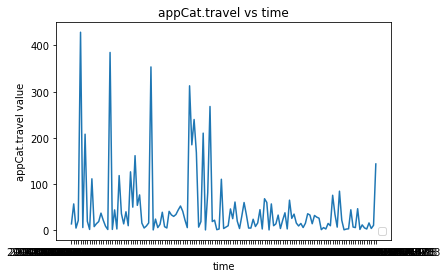

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


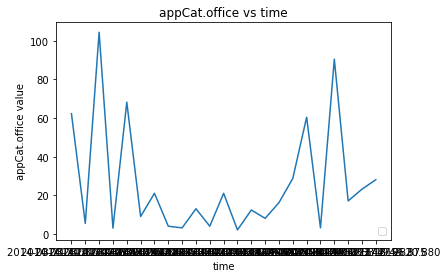

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


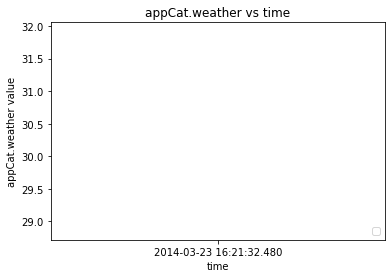

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


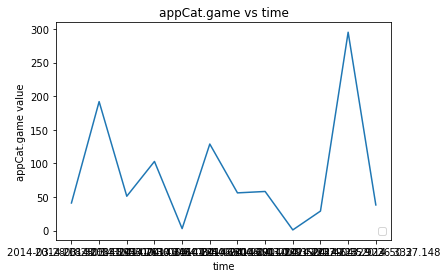

In [13]:
for name in advanced_df['variable'].unique():
    plot_feature(advanced_df, name, 'AS14.01')

## Plot variable values to check for distribution for participant AS14.01

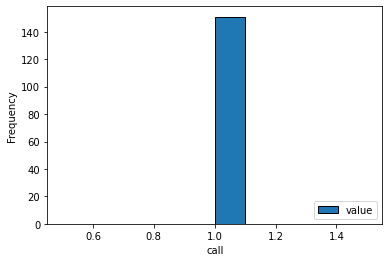

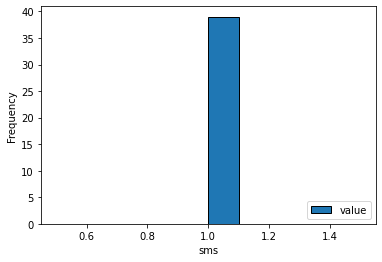

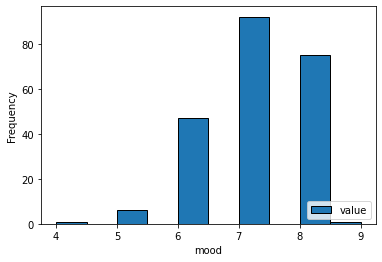

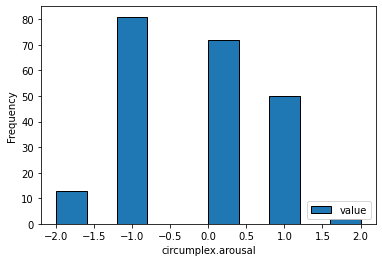

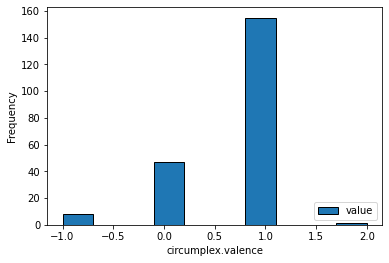

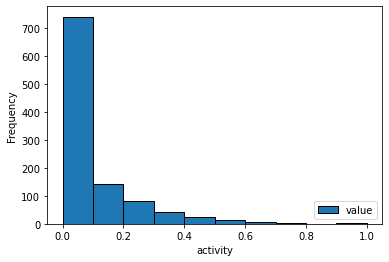

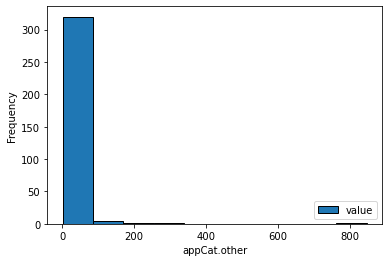

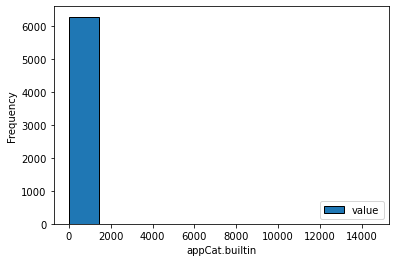

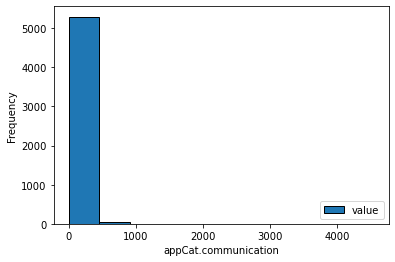

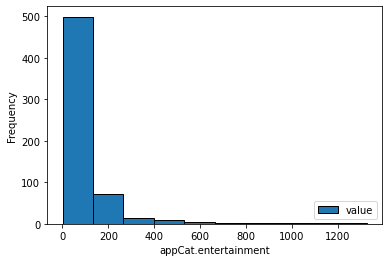

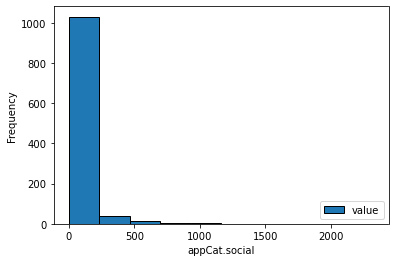

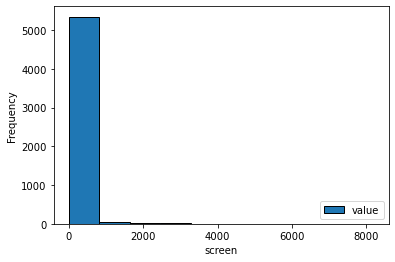

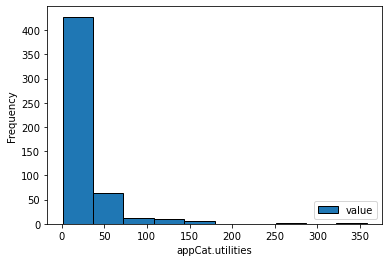

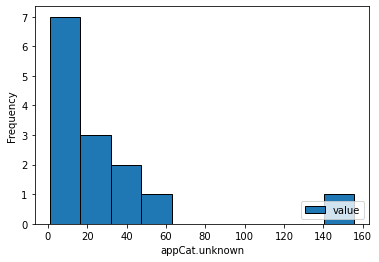

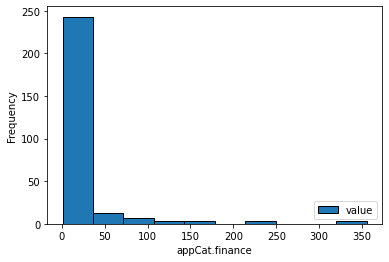

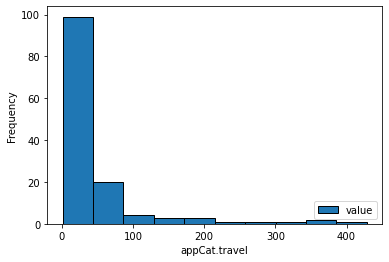

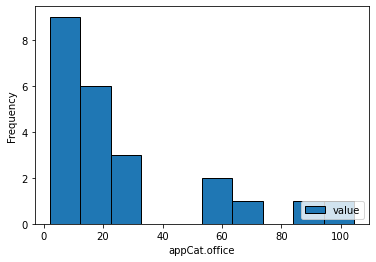

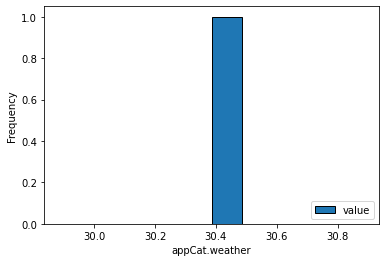

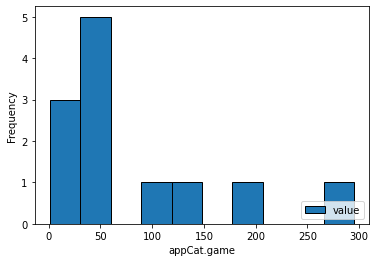

In [14]:
for name in advanced_df['variable'].unique():
    plot_histograms(advanced_df, name, 'AS14.01')

## Calculate mean and sd for each variable

In [15]:
result = advanced_df.groupby('variable')['value'].agg(['mean', 'std'])

## Remove outliers for all participants

In [16]:
filtered_data = []
for name in advanced_df['variable'].unique():
    group = advanced_df[advanced_df['variable'] == name]
    filtered_group = remove_outliers(group, 'value')
    filtered_data.append(filtered_group)

clean_df = pd.concat(filtered_data)

## Check variable distribution for participant AS14.01 with the new data

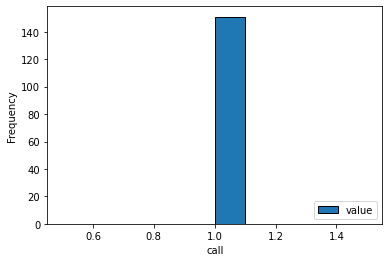

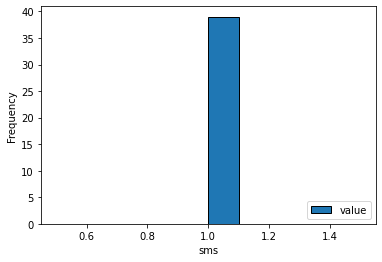

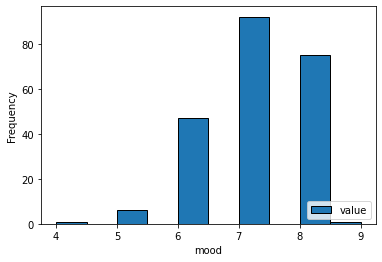

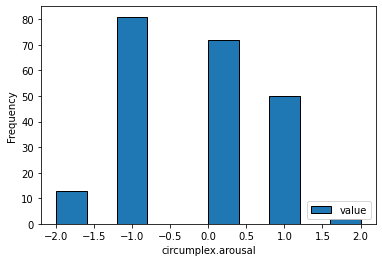

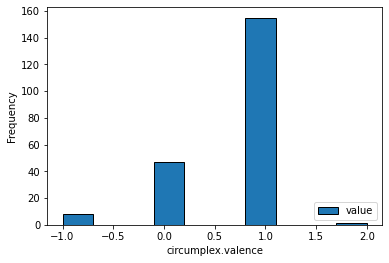

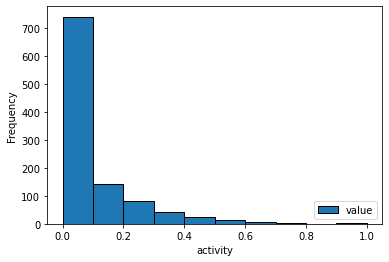

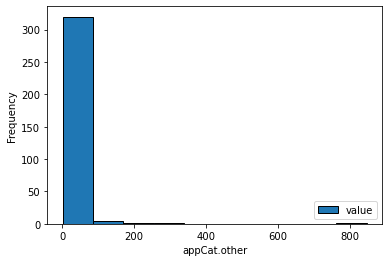

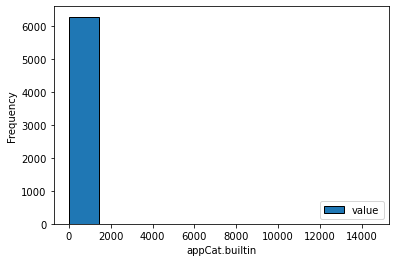

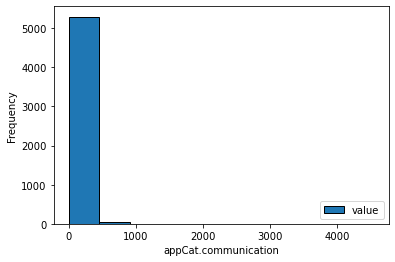

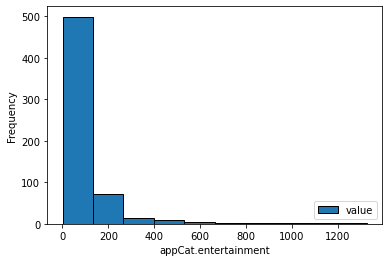

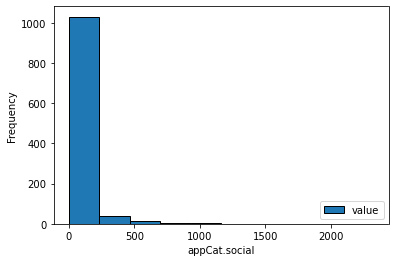

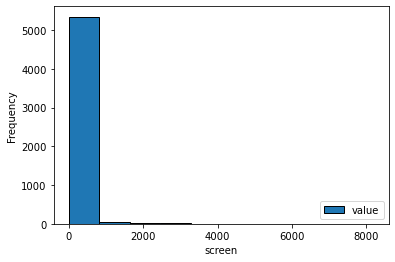

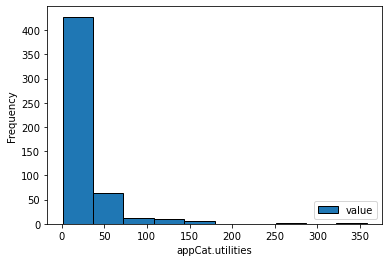

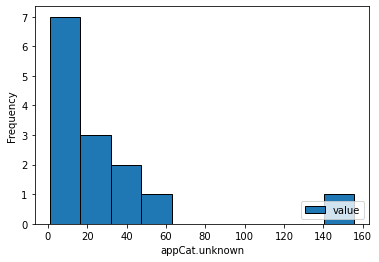

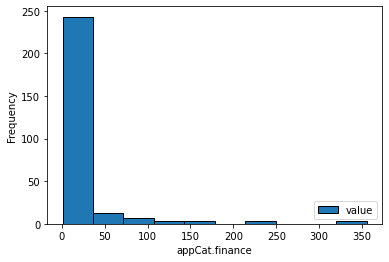

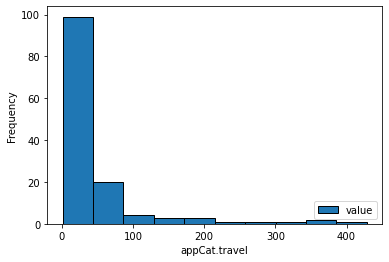

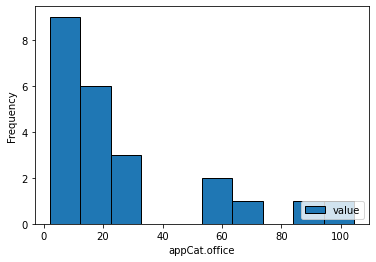

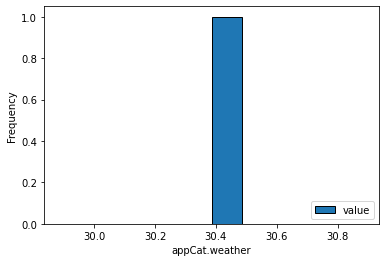

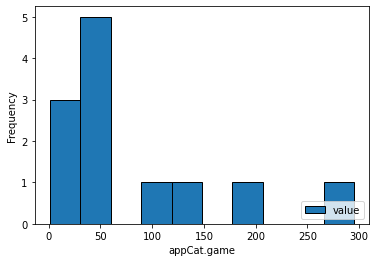

In [17]:
for name in advanced_df['variable'].unique():
    plot_histograms(advanced_df, name, 'AS14.01')

# Data engineering

## For each variable, calculate the average value if the variable is continuous and the count if the value is categorical, for each day, and distinguish the variable column to different features.

In [18]:
# Convert timestamp to datetime object and extract date
clean_df['time'] = pd.to_datetime(clean_df['time']).dt.date

# List of continuous and categorical variables
continuous_vars = ['mood', 'screen', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'circumplex.arousal', 'circumplex.valence', 'activity']
categorical_vars = ['call', 'sms']

# Define aggregation functions for continuous and categorical variables
aggregations = {}
for var in continuous_vars:
    aggregations[var] = 'mean'
for var in categorical_vars:
    aggregations[var] = 'count'


In [19]:
# Filter the dataframe for continuous and categorical variables
cont_df = clean_df[clean_df['variable'].isin(continuous_vars)].pivot_table(index=['id', 'time'], columns='variable', values='value').reset_index()
cat_df = clean_df[clean_df['variable'].isin(categorical_vars)].pivot_table(index=['id', 'time'], columns='variable', values='value', aggfunc='count').reset_index()

# Merge the dataframes
result = pd.merge(cont_df, cat_df, on=['id', 'time'], how='outer')

# Replace all NaN values with 0
result.fillna(0, inplace=True)

# ML classifier

In [20]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

## Section for classic ML models

In [21]:
X = result.loc[:,result.columns != 'mood']
y = result['mood']

In [22]:
y = y.round().astype(int)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Check for class balance

In [24]:
y_train = pd.DataFrame(y_train)
check_class_balance(y_train, 'mood')

0    571
7    555
8    285
6    157
9     10
Name: mood, dtype: int64


## We need to balance these classes to train the model, if not the model will be biased towards predicting more 0s and 7s

## Upsampling with SMOTE

## Section for ARIMA model. The difference is that ARIMA does not need the rest features, only time and mood.